In [1]:

import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from swimnetworks import Dense, Linear

from dataset.dataset import Dataset
from models.base_model import BaseModel
from models.neural_net import NeuralNet
from models.sampled_net import SampledNet
from utils.layer1_logic import compute_weights_biases_layer1
from view.visualizer import plot_vector_differences, plot_weight_biases_differences, plot_weight_vectors_and_point_pairs


In [2]:


xd = 2  # Input space dimensions
yd = 4  # Output dimension
num_samples = 50  # Number of data points
layer_width = 20

dataset = Dataset()
dataset.create_dataset_sinus_2d(num_samples)
dataset.scale(preprocessing.MinMaxScaler(feature_range=(-2, 2)))
dataset.split_train_test(0.2)

### Train network with swim

In [3]:

steps = [
    (
        "dense",
        Dense(
            layer_width=layer_width,
            activation="relu",
            parameter_sampler="relu",
            random_seed=42,
        ),
    ),
    ("linear", Linear(regularization_scale=1e-10)),
]
model_swim = Pipeline(steps)

model_swim.fit(dataset.X_train, dataset.y_train)

model_base = BaseModel()

model_base.weights = [
    model_swim.get_params()["steps"][0][1].weights,
    model_swim.get_params()["steps"][1][1].weights,
]
model_base.biases = [
    -model_swim.get_params()["steps"][0][1].biases[0],
    -model_swim.get_params()["steps"][1][1].biases[0],
]

y_predict = model_base.predict(dataset.X_test)
y_swim = model_swim.predict(dataset.X_test)

print(f"Predictions from 'model_base' and 'model_swim' are equal: {np.array_equal(y_predict, y_swim)}")

Predictions from 'model_base' and 'model_swim' are equal: True


### train network with Adam

In [4]:
# model_adam = NeuralNet()
# model_adam.fit(dataset.X_train, dataset.y_train, [layer_width], epochs=10)
#
# model_base = model_adam

### Fit SampledNet with the model_base, and visualization of the weight angles and bias differences of the first layer, and weight vs x_1, x_2 (same direction if model_base is trained with Swim)

Layer1 sampling: 100%|██████████| 20/20 [00:00<00:00, 1480.60it/s]

weights1 equals weights2:  False


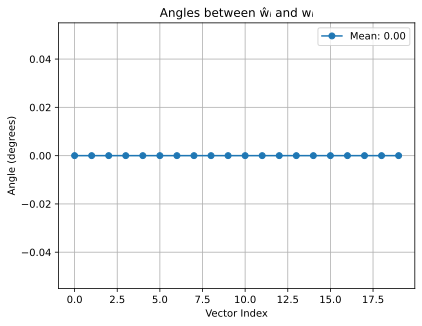

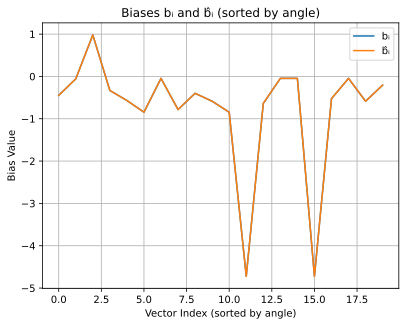

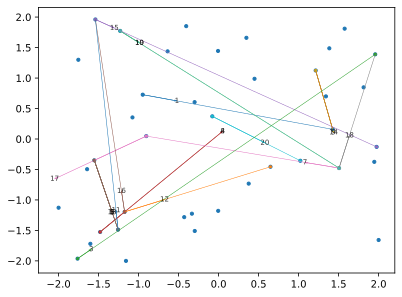

In [5]:
y_nn_train = model_base.predict(dataset.X_train)

model_sampled = SampledNet()
x_1_x2_tuples = model_sampled.fit(dataset.X_train, y_nn_train, model_base, layer2="classic", radius=0.05,
                                  project_onto_boundary=False)

plot_weight_biases_differences(
    model_base.weights[0], model_sampled.weights[0], model_base.biases[0], model_sampled.biases[0]
)

plot_weight_vectors_and_point_pairs(dataset.X_train, x_1_x2_tuples, np.transpose(model_base.weights[0]))

### visualize the num_vectors_to_visualize weight and (x_1,x_2) vectors during training of a network with adam. sorted by weight norm.

Final Validation Loss: 0.4971


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 4267.06it/s]


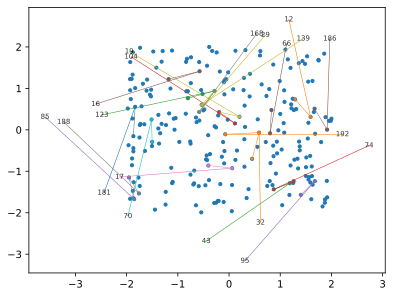

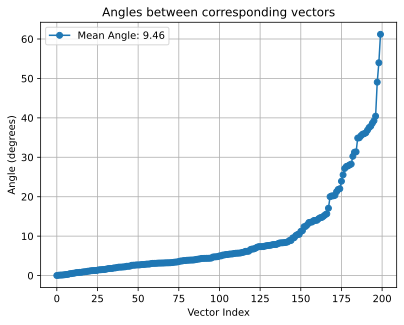

Final Validation Loss: 0.3550


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 10338.82it/s]


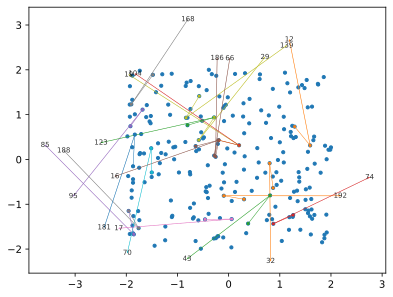

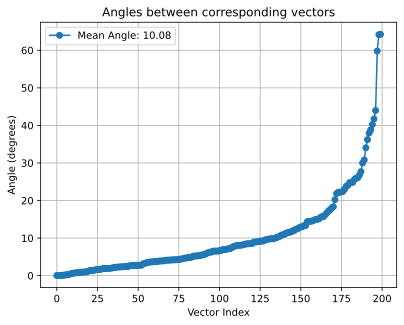

Final Validation Loss: 0.2810


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 5651.18it/s]


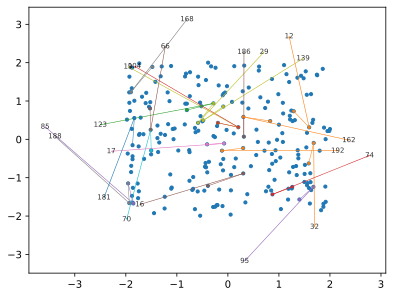

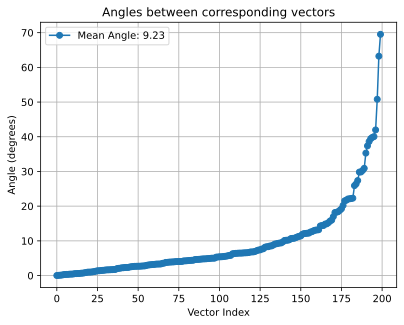

Final Validation Loss: 0.2246


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 4978.14it/s]


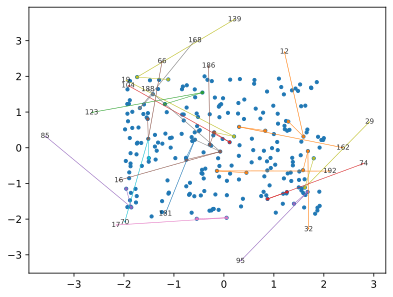

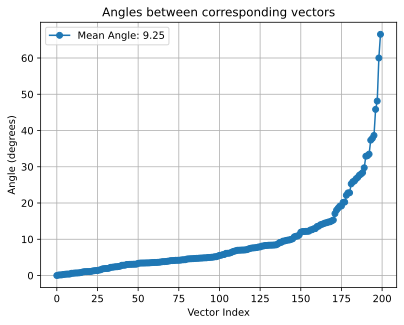

Final Validation Loss: 0.1680


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 11684.93it/s]


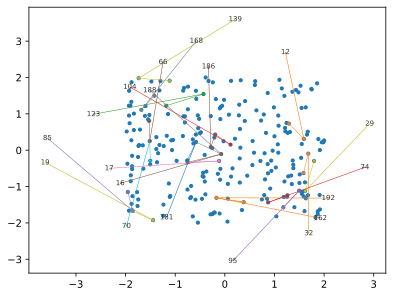

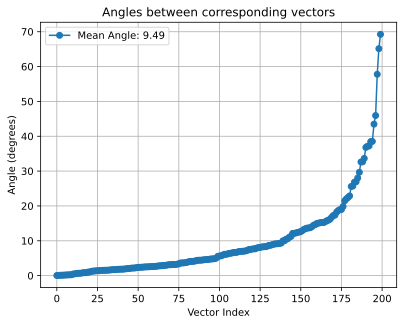

Final Validation Loss: 0.1232


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 8012.12it/s]


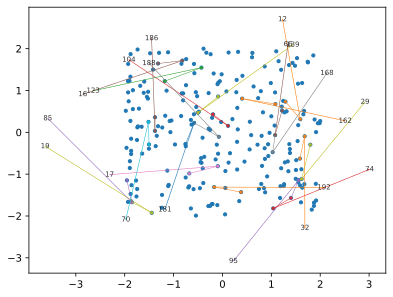

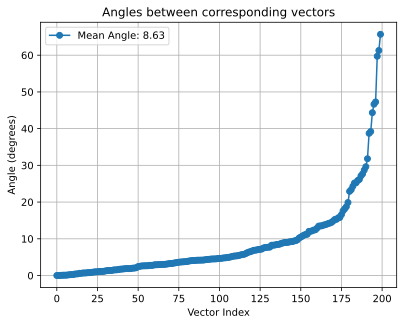

Final Validation Loss: 0.0957


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 6399.46it/s]


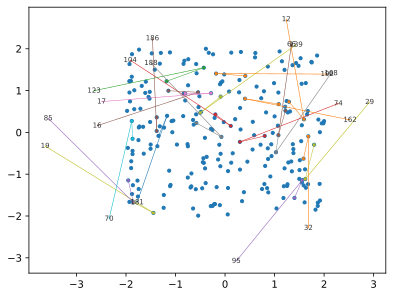

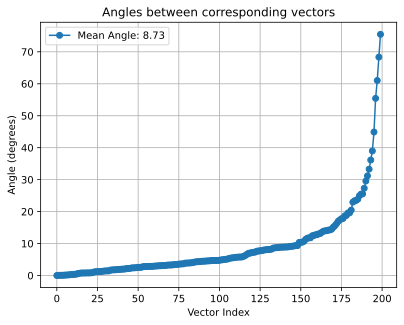

Final Validation Loss: 0.0740


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 6400.93it/s]


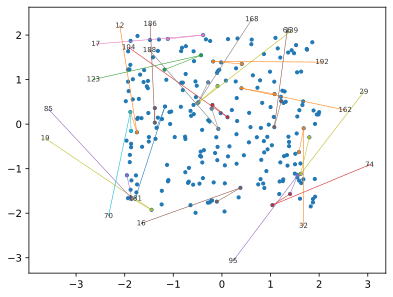

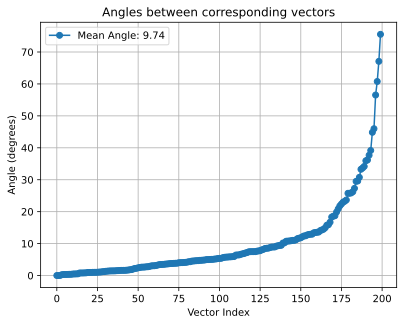

Final Validation Loss: 0.0629


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 12802.54it/s]


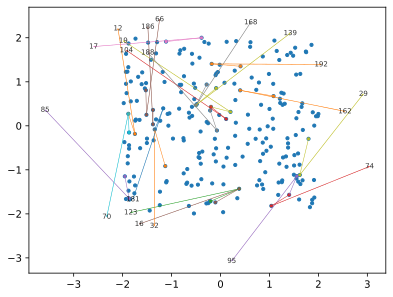

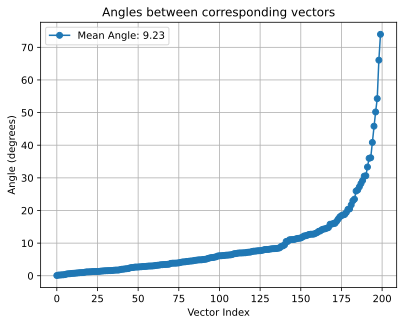

Final Validation Loss: 0.0544


Layer1 sampling: 100%|██████████| 200/200 [00:00<00:00, 7343.03it/s]


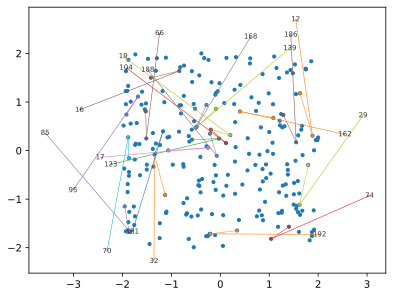

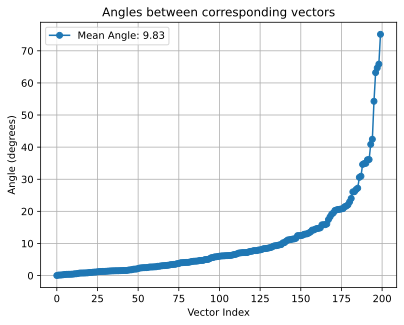

In [6]:

xd = 2  # Input space dimensions
num_samples = 300  # Number of data points
layer_width = 200

initial_epochs = 20
d_epochs = 20
num_intervals = 10

num_vectors_to_visualize = 20

dataset = Dataset().create_dataset_sinus_2d(num_samples)
dataset.scale(preprocessing.MinMaxScaler(feature_range=(-2, 2)))
dataset.split_train_test(0.2)

model = NeuralNet()

model.fit(dataset.X_train, dataset.y_train, layers=[layer_width], epochs=initial_epochs, validation_split=0.3)
x = model.model.evaluate(dataset.X_test, dataset.y_test, verbose=0)

# Initial training
for i in range(num_intervals):
    model.resume_training(
        dataset.X_train,
        dataset.y_train,
        initial_epoch=initial_epochs,
        epochs=initial_epochs + d_epochs,
        validation_split=0.2,
    )

    # Evaluate the model after additional training
    x = model.model.evaluate(dataset.X_test, dataset.y_test, verbose=0)

    print(f"Final Validation Loss: {x:.4f}")
    weights_l1, biases_l1, x_1_x2_tuples = compute_weights_biases_layer1(
        dataset.X_train, model.weights, model.biases, radius=0.0
    )

    # plot_vector_differences([weights_l1], [model.weights[0]])

    plot_weight_vectors_and_point_pairs(
        dataset.X_train, x_1_x2_tuples, np.transpose(model.weights[0]), num_vectors=num_vectors_to_visualize
    )
    plot_vector_differences([model.weights[0]], [weights_l1])
    initial_epochs += d_epochs
